In [1]:
# In prep
import pandas as pd
import utm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.nonparametric.smoothers_lowess import lowess

seed = 38 # Seed for train/val split

In [2]:
#Function to convert geographic to projected coordinates
def from_latlon(lat, lon):
    easting, northing, zone_num, zone_letter = utm.from_latlon(lat, lon)
    return easting, northing, zone_num, zone_letter

In [3]:
def preprocess_sim_data(sim_data, data_type, freq, tower_locs):
    # Get data
    sim_dat_filt = sim_data[sim_data['Data_type'].isin(data_type)]
    
    # make column with the datetime to nearest 'freq' value (e.g. 5min)
    sim_dat_filt = sim_dat_filt.assign(DateTime = sim_dat_filt['DateAndTime'].dt.floor(freq=freq))

    # group by datetime, tag, tower and antenna, compute mean power, pivot to antennas
    sim_dat_filt = (
        sim_dat_filt.groupby(['DateTime', 'TowerID', 'TagID', 'Antenna', 'POINT_X', 'POINT_Y'])['Power']
        .sum()
        .reset_index()
        .pivot_table(index=['DateTime', 'TowerID', 'TagID', 'POINT_X', 'POINT_Y'], columns='Antenna', values='Power')
        .reset_index()
        .rename(columns={1: 'ant1', 2: 'ant2', 3: 'ant3', 4: 'ant4'})
        .fillna(value=0) # Need to check the impact of this
    )
    # Calculate easting and northing from lat long
    sim_dat_filt['easting'], sim_dat_filt['northing'], sim_dat_filt['zone_num'], sim_dat_filt['zone_letter'] = from_latlon(sim_dat_filt['POINT_Y'].values, sim_dat_filt['POINT_X'].values)

    # Create a dictionary of the coordinates of the towers
    offset_dict = tower_locs.set_index('TowerID').to_dict()
    point_x = offset_dict['POINT_X']
    point_y = offset_dict['POINT_Y']

    # Standardise the coordinates so that the tower location == 0 on both the x and y axes.
    sim_dat_filt['xOffset'] = sim_dat_filt['easting'] - sim_dat_filt['TowerID'].map(point_x).fillna(0)
    sim_dat_filt['yOffset'] = sim_dat_filt['northing'] - sim_dat_filt['TowerID'].map(point_y).fillna(0)

    return sim_dat_filt

In [4]:
# Get training data
train_data = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Simul_data\Processed_RTdat_w_LatLong_append\RTdat_sim_train_20230212.xlsx'
train_data = pd.read_excel(train_data)
train_data['DateAndTime'] = pd.to_datetime(train_data['DateAndTime'])

# Get testing data
test_data = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Simul_data\Processed_RTdat_w_LatLong_append\RTdat_sim_test_20230212.xlsx'
test_data = pd.read_excel(test_data)
test_data['DateAndTime'] = pd.to_datetime(test_data['DateAndTime'])

# Get tower locations
radio_tower_xy_path = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Tower_data\RTEastNorth.xlsx'
tower_locs = pd.read_excel(radio_tower_xy_path)


In [5]:
# Initial pass over the data using lazy predict to identify possible options
# import lazypredict
# from lazypredict.Supervised import LazyRegressor
# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# print(models)

In [6]:
# Drilling into top performing models for paramater optimisation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

# Create a list of test dictionaries
KNeighborsRegressor_params = [{"n_neighbors":3}, {"n_neighbors":5}, {"n_neighbors":7}]
AdaBoostRegressor_params = [{"n_estimators":25}, {"n_estimators":50}, {"n_estimators":75}]

# Create classes for the models
modelclasses = [
    ["K neighbours regressor", KNeighborsRegressor, KNeighborsRegressor_params],
    ["Ada boost regressor", AdaBoostRegressor, AdaBoostRegressor_params]
]

In [7]:
# Pre-processing parameters to test
# Variable parameters
data_type = ['Simulation'] # Simulation or Live BTF, or could do both
frequencies = ['1min', '3min', '5min', '10min']
cv = [] #To be updated

# Fixed parameters
dimensions = ['xOffset', 'yOffset']
predictors = ['ant1', 'ant2', 'ant3', 'ant4']
responses = ['xOffset', 'yOffset']
scoring = 'neg_mean_absolute_error'

trained_models = []
for dimension in dimensions:
    for freq in frequencies:
        sim_data_preproc = preprocess_sim_data(train_data, data_type, freq, tower_locs)
        X_train = sim_data_preproc[predictors]
        y_train = sim_data_preproc[dimension] # Will need to adjust this to iterate over x and y xOffset

        # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

        for modelname, Model, params_list in modelclasses:
            for params in params_list:
                model = Model(**params)
                scores = cross_val_score(model, X_train, y_train, cv=3, scoring=scoring)
                score = np.mean(scores)
                model.fit(X_train, y_train)
                trained_models.append((dimension, modelname, model, params, freq, score))

In [8]:
best_models = []
for dimension in dimensions:
    filtered = [x for x in trained_models if x[0] == dimension]
    filtered.sort(key=lambda x:x[-1], reverse=True)
    best_model = filtered[0]
    best_models.append(best_model)
    print(f"\nThe best performing model for {dimension} was {best_model}\n\nAll model results as follows:")

    for dimension, modelname, model, params, freq, score in filtered:
        print(dimension, modelname, params, freq, score)        


The best performing model for xOffset was ('xOffset', 'Ada boost regressor', AdaBoostRegressor(), {'n_estimators': 50}, '1min', -239.2870675481861)

All model results as follows:
xOffset Ada boost regressor {'n_estimators': 50} 1min -239.2870675481861
xOffset Ada boost regressor {'n_estimators': 75} 1min -241.0987107510156
xOffset Ada boost regressor {'n_estimators': 25} 1min -241.92549728928802
xOffset K neighbours regressor {'n_neighbors': 7} 1min -242.54764589998786
xOffset K neighbours regressor {'n_neighbors': 5} 1min -245.9988700529381
xOffset Ada boost regressor {'n_estimators': 75} 5min -248.5209132186084
xOffset Ada boost regressor {'n_estimators': 75} 3min -249.06583247689935
xOffset Ada boost regressor {'n_estimators': 25} 3min -249.0944317290534
xOffset Ada boost regressor {'n_estimators': 50} 5min -250.05206167282617
xOffset Ada boost regressor {'n_estimators': 50} 3min -250.22959416876446
xOffset Ada boost regressor {'n_estimators': 25} 5min -250.72243316008476
xOffset K

In [9]:
# Pre-process test data
sim_data_preproc = preprocess_sim_data(test_data, data_type, freq, tower_locs) #### Change this to Test data

# Isolate predictor variables from test data
X_test = sim_data_preproc[predictors]

for dimension in dimensions:
    best_model = [x for x in best_models if x[0] == dimension]
    model = best_model[0][2]
    freq = best_model[0][4]

    # Isolate response variable from test data
    y_test = sim_data_preproc[dimension]

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Save predictions to a new column in the test data pandas dataframe
    pred_column_name = f"{dimension}_pred"
    sim_data_preproc[pred_column_name] = y_pred

    # # Save frequency of predictions to the pandas dataframe !!!!!!!!!!Consider deleting, I don't think it's needed
    # freq_column_name = f"{dimension}_freq"
    # sim_data_preproc[freq_column_name] = freq

In [10]:
sim_data_preproc

Antenna,DateTime,TowerID,TagID,POINT_X,POINT_Y,ant1,ant2,ant3,ant4,easting,northing,zone_num,zone_letter,xOffset,yOffset,xOffset_pred,yOffset_pred
0,2021-02-10 16:21:00,RT01,50,146.255721,-21.919832,0.0,173.0,0.0,96.0,423130.217989,7.575860e+06,55,K,-208.513195,-58.404739,-126.541051,-89.926403
1,2021-02-10 16:21:00,RT03,50,146.255721,-21.919832,92.0,0.0,0.0,0.0,423130.217989,7.575860e+06,55,K,-258.702082,449.014919,-55.926228,417.683634
2,2021-02-10 16:21:00,RT04,50,146.255721,-21.919832,87.0,0.0,0.0,0.0,423130.217989,7.575860e+06,55,K,184.100128,186.159296,-55.926228,470.410672
3,2021-02-10 16:21:00,RT05,50,146.255721,-21.919832,0.0,66.0,79.0,0.0,423130.217989,7.575860e+06,55,K,185.041847,-312.089655,26.810639,-274.953688
4,2021-02-10 16:22:00,RT01,50,146.255721,-21.919832,0.0,93.0,0.0,98.0,423130.217989,7.575860e+06,55,K,-208.513195,-58.404739,-115.992430,-150.184903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,2021-04-23 15:31:00,RT08,8,146.276501,-21.943719,90.0,140.0,69.0,87.0,425288.949674,7.573226e+06,55,K,-85.757804,75.033602,-45.905722,14.393982
486,2021-04-23 15:32:00,RT08,8,146.276501,-21.943719,0.0,62.0,53.0,0.0,425288.949674,7.573226e+06,55,K,-85.757804,75.033602,26.810639,-231.451802
487,2021-04-23 15:35:00,RT08,8,146.276501,-21.943719,87.0,133.0,69.0,94.0,425288.949674,7.573226e+06,55,K,-85.757804,75.033602,-45.905722,-7.577853
488,2021-04-23 15:36:00,RT08,8,146.276501,-21.943719,89.0,66.0,68.0,88.0,425288.949674,7.573226e+06,55,K,-85.757804,75.033602,-126.541051,24.619858


In [11]:
#Convert locations predictions back to easting northings

def postprocess_data(prediction_data, tower_locs):
    # Create a dictionary of the coordinates of the towers
    offset_dict = tower_locs.set_index('TowerID').to_dict()
    point_x = offset_dict['POINT_X']
    point_y = offset_dict['POINT_Y']

    # Change predicted x/y offset values to their respective easting/northing considering the location of the tower
    prediction_data['easting_pred'] = prediction_data['xOffset_pred'] + prediction_data['TowerID'].map(point_x).fillna(0)
    prediction_data['northing_pred'] = prediction_data['yOffset_pred'] + prediction_data['TowerID'].map(point_y).fillna(0)
    
    return prediction_data

In [12]:
test_predictions = postprocess_data(sim_data_preproc, tower_locs)



##########Consider removing zone_num and zone_letter from output

In [13]:
test_predictions

Antenna,DateTime,TowerID,TagID,POINT_X,POINT_Y,ant1,ant2,ant3,ant4,easting,northing,zone_num,zone_letter,xOffset,yOffset,xOffset_pred,yOffset_pred,easting_pred,northing_pred
0,2021-02-10 16:21:00,RT01,50,146.255721,-21.919832,0.0,173.0,0.0,96.0,423130.217989,7.575860e+06,55,K,-208.513195,-58.404739,-126.541051,-89.926403,423212.190133,7.575829e+06
1,2021-02-10 16:21:00,RT03,50,146.255721,-21.919832,92.0,0.0,0.0,0.0,423130.217989,7.575860e+06,55,K,-258.702082,449.014919,-55.926228,417.683634,423332.993843,7.575829e+06
2,2021-02-10 16:21:00,RT04,50,146.255721,-21.919832,87.0,0.0,0.0,0.0,423130.217989,7.575860e+06,55,K,184.100128,186.159296,-55.926228,470.410672,422890.191633,7.576144e+06
3,2021-02-10 16:21:00,RT05,50,146.255721,-21.919832,0.0,66.0,79.0,0.0,423130.217989,7.575860e+06,55,K,185.041847,-312.089655,26.810639,-274.953688,422971.986781,7.575897e+06
4,2021-02-10 16:22:00,RT01,50,146.255721,-21.919832,0.0,93.0,0.0,98.0,423130.217989,7.575860e+06,55,K,-208.513195,-58.404739,-115.992430,-150.184903,423222.738754,7.575768e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,2021-04-23 15:31:00,RT08,8,146.276501,-21.943719,90.0,140.0,69.0,87.0,425288.949674,7.573226e+06,55,K,-85.757804,75.033602,-45.905722,14.393982,425328.801756,7.573166e+06
486,2021-04-23 15:32:00,RT08,8,146.276501,-21.943719,0.0,62.0,53.0,0.0,425288.949674,7.573226e+06,55,K,-85.757804,75.033602,26.810639,-231.451802,425401.518117,7.572920e+06
487,2021-04-23 15:35:00,RT08,8,146.276501,-21.943719,87.0,133.0,69.0,94.0,425288.949674,7.573226e+06,55,K,-85.757804,75.033602,-45.905722,-7.577853,425328.801756,7.573144e+06
488,2021-04-23 15:36:00,RT08,8,146.276501,-21.943719,89.0,66.0,68.0,88.0,425288.949674,7.573226e+06,55,K,-85.757804,75.033602,-126.541051,24.619858,425248.166427,7.573176e+06


In [14]:
# Average easting and northings across time interval
UTM_predictions = (test_predictions.groupby(['DateTime', 'TagID'], as_index=False)
    .agg({'easting':'first',
        'northing':'first',
        'easting_pred':'mean',
        'northing_pred':'mean'
        })
)

UTM_predictions

#potentially add a spline?, or use a spline in the place of the average? Lowess smoothing function looks good

Antenna,DateTime,TagID,easting,northing,easting_pred,northing_pred
0,2021-02-10 16:21:00,50,423130.217989,7.575860e+06,423101.840598,7.575925e+06
1,2021-02-10 16:22:00,50,423130.217989,7.575860e+06,423115.174192,7.575724e+06
2,2021-02-10 16:23:00,50,423130.217989,7.575860e+06,423066.138178,7.575942e+06
3,2021-02-10 16:24:00,50,423130.217989,7.575860e+06,422989.167095,7.575746e+06
4,2021-02-10 16:25:00,50,423091.031419,7.575847e+06,423195.928527,7.575943e+06
...,...,...,...,...,...,...
226,2021-04-23 15:31:00,8,425288.949674,7.573226e+06,425328.801756,7.573166e+06
227,2021-04-23 15:32:00,8,425288.949674,7.573226e+06,425401.518117,7.572920e+06
228,2021-04-23 15:35:00,8,425288.949674,7.573226e+06,425328.801756,7.573144e+06
229,2021-04-23 15:36:00,8,425288.949674,7.573226e+06,425248.166427,7.573176e+06


In [15]:
######## update this code to apply for both the x and y offset
max_gap_4_smoothing = 10 # in minutes

UTM_predictions = UTM_predictions.sort_values(by='DateTime')
tag_ids = UTM_predictions['TagID'].unique()

# Loop through each unique value of 'TagID'
for tag_id in tag_ids:
    # Filter the dataframe to only include rows with the current 'TagID'
    UTM_predictions_filtered = UTM_predictions[UTM_predictions['TagID'] == tag_id].copy()
    
    # Calculate the difference in minutes between each DateTime
    UTM_predictions_filtered['diff'] = UTM_predictions_filtered['DateTime'].diff().dt.total_seconds() / 60
    
    # Find the indices where the difference is greater than 10 minutes
    split_indices = UTM_predictions_filtered[UTM_predictions_filtered['diff'] > max_gap_4_smoothing].index
    
    # Split the filtered dataframe into subsets based on the split_indices
    split_data = np.split(UTM_predictions_filtered, split_indices)
    
    # Loop through each subset of the dataframe
    for subset in split_data:
        index_list = subset.index
        if len(subset) < 2:
            UTM_predictions.loc[index_list, 'easting_pred_smooth'] = UTM_predictions.loc[index_list, 'easting_pred']
            UTM_predictions.loc[index_list, 'northing_pred_smooth'] = UTM_predictions.loc[index_list, 'northing_pred']
        else:
            smoothed_values_easting = lowess(subset['easting_pred'], subset['DateTime'], is_sorted=False, return_sorted=False)
            smoothed_values_northing = lowess(subset['northing_pred'], subset['DateTime'], is_sorted=False, return_sorted=False)
            UTM_predictions.loc[index_list, 'easting_pred_smooth'] = smoothed_values_easting
            UTM_predictions.loc[index_list, 'northing_pred_smooth'] = smoothed_values_northing

# easting
y_true = UTM_predictions['easting']
y_pred = UTM_predictions['easting_pred_smooth']
error = mean_absolute_error(y_true, y_pred)
print(f'Easting smoothed MAE = {error}')

y_true = UTM_predictions['easting']
y_pred = UTM_predictions['easting_pred']
error = mean_absolute_error(y_true, y_pred)
print(f'Easting unsmoothed MAE = {error}')

# northing
y_true = UTM_predictions['northing']
y_pred = UTM_predictions['northing_pred_smooth']
error = mean_absolute_error(y_true, y_pred)
print(f'Northing smoothed MAE = {error}')

y_true = UTM_predictions['northing']
y_pred = UTM_predictions['northing_pred']
error = mean_absolute_error(y_true, y_pred)
print(f'Northing unsmoothed MAE = {error}')


Easting smoothed MAE = 369.5456781874283
Easting unsmoothed MAE = 168.82783131654125
Northing smoothed MAE = 300.75386939848494
Northing unsmoothed MAE = 152.42107521291436


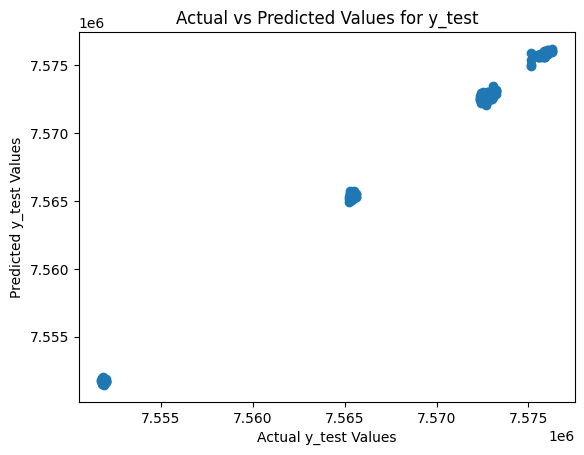

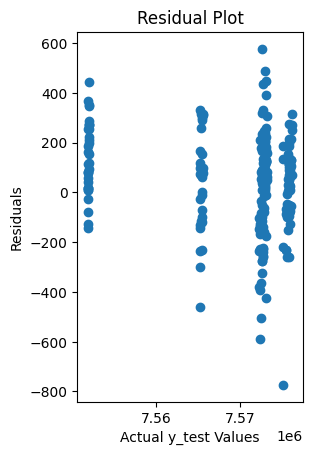

In [16]:
####### these plots would be better at the point of the tower estimates

# Plot the estimated vs actual predictions
plt.scatter(y_true, y_pred)
plt.xlabel("Actual y_test Values")
plt.ylabel("Predicted y_test Values")
plt.title("Actual vs Predicted Values for y_test")
plt.show()

# Plot the residuals
residuals = y_true - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_true, residuals)
plt.xlabel("Actual y_test Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [17]:
#Break to generate exports for checking data

break

SyntaxError: 'break' outside loop (3192701957.py, line 3)

In [18]:
def plot_xy(x, y):
    plt.plot(x, y, 'o')
    plt.xlabel('xOffset')
    plt.ylabel('yOffset')
    plt.title('XY plot of xOffset vs. yOffset')
    plt.show()

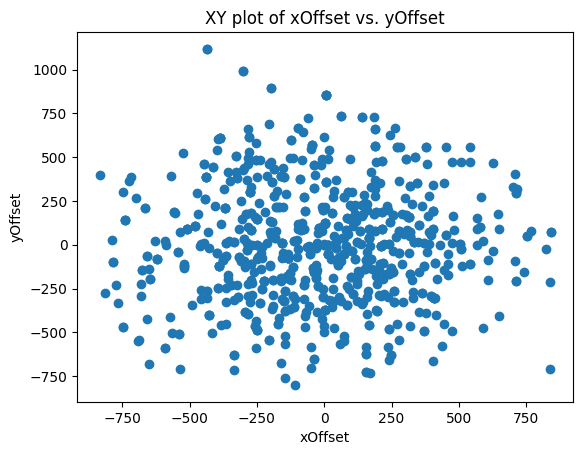

In [19]:
#Plot to check for outliers
df = train_data

sim_data_preproc = preprocess_sim_data(df, data_type, freq, tower_locs)
x = sim_data_preproc['xOffset']
y = sim_data_preproc['yOffset']
plot_xy(x,y)

In [ ]:
output_path = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Simul_data\Processed_RTdat_w_LatLong_append\\train_data_processed_check_20230214_JVO.xlsx'

sim_data_preproc.to_excel(output_path, index=False)